## Libraries import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

np.random.seed(22)

## Data import

In [ ]:
def load_data():
    """
    Load and preprocess Wine Quality dataset from the csv files

    Returns tuple of X_train, X_test, y_train, y_test
    """

    df_red = pd.read_csv('winequality-red.csv', sep=';')
    df_red['wine_type'] = 'Red'

    df_white = pd.read_csv('winequality-white.csv', sep=';')
    df_white['wine_type'] = 'White'

    df = pd.concat([df_red, df_white], axis=0, ignore_index=True)
    df['quality_binary'] = (df['quality'] >= 6).astype(int)

    # Plot distribution
    fig, ax = plt.subplots(figsize=(10, 6))

    # Count wines by type and quality
    red_bad = len(df[(df['wine_type'] == 'Red') & (df['quality_binary'] == 0)])
    red_good = len(df[(df['wine_type'] == 'Red') & (df['quality_binary'] == 1)])
    white_bad = len(df[(df['wine_type'] == 'White') & (df['quality_binary'] == 0)])
    white_good = len(df[(df['wine_type'] == 'White') & (df['quality_binary'] == 1)])

    x = np.arange(2)
    width = 0.6

    bars1 = ax.bar(x, [red_bad, red_good], width, label='Red Wine', color='darkred', alpha=0.8)
    bars2 = ax.bar(x, [white_bad, white_good], width, bottom=[red_bad, red_good],
                   label='White Wine', color='gold', alpha=0.8)

    ax.set_xlabel('Wine Quality', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Wines', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Red and White Wines by Quality', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Bad (quality < 6)', 'Good (quality ≥ 6)'])
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    # Red wine labels
    for i, (bar, val) in enumerate(zip(bars1, [red_bad, red_good])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
               f'Red: {int(val)}',
               ha='center', va='center', fontweight='bold', color='white', fontsize=10)

    # White wine labels
    for i, (bar, val, bottom) in enumerate(zip(bars2, [white_bad, white_good], [red_bad, red_good])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., bottom + height/2,
               f'White: {int(val)}',
               ha='center', va='center', fontweight='bold', color='black', fontsize=10)

    # Total labels on top
    for i, (total, x_pos) in enumerate(zip([red_bad + white_bad, red_good + white_good], x)):
        ax.text(x_pos, total + 50, f'Total: {int(total)}',
               ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.savefig('wine_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

    # convert labels to {-1, 1})
    X = df.drop(['quality', 'quality_binary', 'wine_type'], axis=1).values
    y = np.where(df['quality_binary'] == 0, -1, 1)

    # Standardize features
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X = (X - mean) / (std + 1e-8)

    # Train-test split (80-20)
    n_train = int(0.8 * len(X))
    indices = np.random.permutation(len(X))
    train_idx, test_idx = indices[:n_train], indices[n_train:]

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(f"Dataset: {len(df)} samples, {X.shape[1]} features")
    print(f"  Red wines:   {len(df_red)} ({red_bad} bad, {red_good} good)")
    print(f"  White wines: {len(df_white)} ({white_bad} bad, {white_good} good)")
    print(f"\nTrain: {len(X_train)}, Test: {len(X_test)}")
    print(f"Class distribution: {np.sum(y_train == 1)} positive, {np.sum(y_train == -1)} negative\n")

    return X_train, X_test, y_train, y_test

## Logistic regression

In [ ]:
class LogisticRegression:
    """
    Logistic regression using Online Gradient Descent
    """

    def __init__(self, eta=0.01, lam=1.0, T=1000):
        self.eta = eta
        self.lam = lam
        self.T = T
        self.w = None
        self.losses = []

    def _sigmoid(self, z):
        """
        Sigmoid function
        """
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _logistic_loss(self, w, x, y):
        """
        Logistic loss: log(1 + exp(-y*w^T*x))
        """
        margin = y * np.dot(w, x)
        return np.log(1 + np.exp(-margin))

    def fit(self, X, y):
        """
        Online Gradient Descent for logistic loss with regularization
        """
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        for t in range(1, self.T + 1):
            # Random sample
            i = np.random.randint(0, n_samples)
            x_i, y_i = X[i], y[i]

            # Gradient: -y_i * sigmoid(-y_i * w^T x_i) * x_i + lambda * w
            sig = self._sigmoid(-y_i * np.dot(self.w, x_i))
            grad = -y_i * sig * x_i + self.lam * self.w

            # Update with decreasing learning rate
            eta_t = self.eta / np.sqrt(t)
            self.w = self.w - eta_t * grad

            # Track loss
            if t % 50 == 0:
                loss = np.mean([self._logistic_loss(self.w, X[j], y[j]) for j in range(n_samples)])
                self.losses.append(loss)

    def predict(self, X):
        """
        Predict class labels
        """
        return np.sign(np.dot(X, self.w))


## SVM (Pegasos)

In [ ]:
class SVM:
    """
    SVM using Pegasos
    """

    def __init__(self, lam=0.01, T=1000):
        self.lam = lam
        self.T = T
        self.w = None
        self.losses = []

    def _hinge_loss(self, w, x, y):
        """
        Hinge loss: max(0, 1 - y*w^T*x)
        """
        margin = 1 - y * np.dot(w, x)
        return max(0, margin)

    def fit(self, X, y):
        """
        Pegasos: Stochastic gradient descent for SVM
        """
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)

        for t in range(1, self.T + 1):
            i = np.random.randint(0, n_samples)
            x_i, y_i = X[i], y[i]

            # Gradient of hinge loss and regularization
            margin = y_i * np.dot(self.w, x_i)
            if margin < 1:
                grad = -y_i * x_i + self.lam * self.w

            eta_t = 1 / (self.lam * t)
            self.w = (1 - 1/t) * self.w - eta_t * grad

            # Save loss
            if t % 50 == 0:
                loss = np.mean([self._hinge_loss(self.w, X[j], y[j]) for j in range(n_samples)])
                self.losses.append(loss)

    def predict(self, X):
        """Predict class labels"""
        return np.sign(np.dot(X, self.w))

## Kernel

In [ ]:
def compute_kernel(X1, X2, kernel='gauss', gamma=0.1, degree=3):
    """
    Compute kernel matrix between matrix X1 and X2
    """
    if kernel == 'gauss':
        # exp(-gamma * ||x - x'||^2)
        sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + \
                   np.sum(X2**2, axis=1).reshape(1, -1) - \
                   2 * np.dot(X1, X2.T)
        return np.exp(-gamma * sq_dists)

    elif kernel == 'poly':
        # (1 + x^T x')^degree
        return (1 + np.dot(X1, X2.T)) ** degree

### Logistic regression

In [ ]:
class KernelLogisticRegression:
    """
    Kernelized Logistic Regression using Gradient Descent
    """

    def __init__(self, kernel='gauss', gamma=0.1, degree=3, lam=1.0, eta=0.01, T=1000):
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.lam = lam
        self.eta = eta
        self.T = T
        self.alpha = None
        self.X_train = None
        self.losses = []

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Train kernel logistic regression
        """
        n_samples = X.shape[0]
        self.X_train = X
        self.alpha = np.zeros(n_samples)

        # Лernel matrix
        K = compute_kernel(self.X_train, self.X_train, self.kernel, self.gamma, self.degree)

        for t in range(1, self.T + 1):
            # Compute predictions
            margin = y * np.dot(K, self.alpha)
            probs = self._sigmoid(-margin)

            # Gradient w.r.t. alpha: -y * sigmoid(-y * f(x)) + lam * alpha
            grad = -y * probs + self.lam * self.alpha

            # Update
            eta_t = self.eta / np.sqrt(t)
            self.alpha -= eta_t * grad

            # Track loss
            if t % 50 == 0:
                # To avoid overflow which happens if calculate loss
                # in normal way (log(1 + exp(-margin)))
                loss = np.mean(np.logaddexp(0, -margin))
                self.losses.append(loss)

    def _logistic_loss(self, w, x, y):
        """
        Logistic loss: log(1 + exp(-y*w^T*x))
        """
        margin = y * np.dot(w, x)
        return np.log(1 + np.exp(-margin))

    def predict(self, X):
        """
        Predict class labels for new data
        """
        K_test = compute_kernel(X, self.X_train, self.kernel, self.gamma, self.degree)
        preds = np.dot(K_test, self.alpha)
        return np.sign(preds)

### SVM

In [ ]:
class KernelSVM:
    """
    Kernelized SVM using the Pegasos algorithm
    """

    def __init__(self, lam=0.01, T=1000, kernel='gauss', gamma=0.1, degree=3):
        """
        Initializes the Kernel SVM model.

        lam: float, regularization parameter
        T: int, number of iterations
        kernel: str, the kernel function to use ('gauss' or 'poly').
        gamma: float, parameter for the Gaussian kernel.
        degree: int, parameter for the polynomial kernel.
        """
        self.lam = lam
        self.T = T
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.losses = []
        self.alpha = None
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        """
        Trains the Kernel SVM using the Kernelized Pegasos algorithm.
        """
        n_samples, _ = X.shape
        self.X_train = X
        self.y_train = y
        self.alpha = np.zeros(n_samples, dtype=np.float64)

        K = compute_kernel(self.X_train, self.X_train, self.kernel, self.gamma, self.degree)

        for t in range(1, self.T + 1):
            i = np.random.randint(0, n_samples)

            decision = np.dot(self.alpha * self.y_train, K[:, i])

            if self.y_train[i] * decision < 1:
                eta_t = 1.0 / (self.lam * t)
                self.alpha[i] += eta_t

            # Track loss
            if t % 50 == 0:
                pred = np.dot(self.alpha * y, K)
                loss = np.mean(np.maximum(0, 1 - y * pred))
                self.losses.append(loss)


    def predict(self, X):
        """
        Predicts class labels for new data.
        """
        if self.alpha is None:
            raise RuntimeError("The model has not been trained yet. Call fit() first.")

        K_pred = compute_kernel(X, self.X_train, self.kernel, self.gamma, self.degree)
        decision_function = np.dot(K_pred, self.alpha * self.y_train)

        return np.sign(decision_function)


## Evaluation

In [ ]:
def accuracy(y_true, y_pred):
    """
    Calculate accuracy
    """
    return np.mean(y_true == y_pred)

def precision(y_true, y_pred):
    """
    Calculate precision
    """
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == -1))
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp)

def recall(y_true, y_pred):
    """
    Calculate recall
    """
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fn = np.sum((y_pred == -1) & (y_true == 1))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn)

def f1_score(y_true, y_pred):
    """
    Calculate F1-score
    """
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    if prec + rec == 0:
        return 0.0
    return 2 * (prec * rec) / (prec + rec)

def evaluate(y_true, y_pred, name):
    """
    Calculate accuracy, precision, recall and f1 score; prints the results
    """
    print(f"\n{name}:")
    acc = accuracy(y_true, y_pred)
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return acc

def cross_validate(model_class, model_params, X, y, k=5):
    """
    K-fold cross-validation
    modelclass: model defined in this notebook
    model_params: dict of parameters for the model
    X, y: df, data of training
    k: int, k for CV
    """
    n_samples = X.shape[0]
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)
    scores = []

    for fold in range(k):
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size if fold < k - 1 else n_samples

        val_idx = indices[start_idx:end_idx]
        train_idx = np.concatenate([indices[:start_idx], indices[end_idx:]])

        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = model_class(**model_params)
        model.fit(X_train, y_train)
        acc = accuracy(y_val, model.predict(X_val))
        scores.append(acc)

    return np.mean(scores), np.std(scores)

## Fine tuning

In [ ]:
def tune_hyperparameters(model_class, X, y, param_grid, k=5):
    """
    Performs a grid search to find the best hyperparameters for a model

    model_class: The class of the model to be tuned
    X, y: the data
    param_grid: dict of parameters for the model
    k: int, the number of folds for cross-validation

    Returns: a tuple containing the best parameter dictionary and the best mean score.
    """
    best_score = -1
    best_params = None

    # Creating all combinations of parameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    print(f"Starting grid search for {len(param_combinations)} parameter combinations...")

    for i, params in enumerate(param_combinations):
        mean_score, std_score = cross_validate(model_class, params, X, y, k=k)
        print(f"[{i+1}/{len(param_combinations)}] Params: {params} -> CV Accuracy: {mean_score:.4f} (+/- {std_score:.4f})")

        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    print("\nGrid search complete.")
    return best_params, best_score


In [ ]:
def parameters_selection(X, y):
    '''
    Chooses the best parameters of models based on greed search

    Returns dictionary where keys are model names and values are
    tuples of (fit model, optimal parameters, resulting accuracy)
    '''
    param_grid_logistic = {
        'eta': [0.1, 0.05, 0.01],
        'lam': [0.01, 0.001],
        'T': [500, 1000, 2000]
        }
    param_grid_svm = {
        'lam': [0.1, 0.01, 0.001],
        'T': [1000, 2000]
        }
    param_grid_gauss_kernel_logistic = {
            'eta': [0.1, 0.05, 0.01],
            'lam': [0.01, 0.001],
            'gamma': [10, 5, 1, 0.1, 0.05, 0.01],
            'T': [1000],
            'kernel': ['gauss']
        }
    param_grid_poly_kernel_logistic = {
            'eta': [0.1, 0.05, 0.01],
            'lam': [0.01, 0.001],
            'T': [1000],
            'kernel': ['poly'],
            'degree': [1, 3, 5, 10]
        }
    param_grid_gauss_kernel_svm = {
        'lam': [0.01, 0.001],
        'T': [1000],
        'kernel': ['gauss'],
        'gamma': [10, 5, 1, 0.1, 0.05, 0.01],
        }
    param_grid_poly_kernel_logistic = {
        'lam': [0.01, 0.001],
        'T': [1000],
        'kernel': ['poly'],
        'degree': [1, 3, 5, 10]
        }
    param_list = [
        {'name': 'Logistic Regression', 'model': LogisticRegression,
        'grid': param_grid_logistic},
        {'name': 'SVM', 'model': SVM,
        'grid': param_grid_svm},
        {'name': 'Gauss kernel logistic regression', 'model': KernelLogisticRegression,
        'grid': param_grid_gauss_kernel_logistic},
        {'name': 'Polynomial Kernel logistic regression', 'model': KernelLogisticRegression,
        'grid': param_grid_poly_kernel_logistic},
        {'name': 'Gauss kernel SVM', 'model': KernelSVM,
        'grid': param_grid_gauss_kernel_svm},
        {'name': 'Polynomial Kernel SVM', 'model': KernelSVM,
        'grid': param_grid_poly_kernel_logistic},
        ]

    res = {}
    for model in param_list:
        print( f"\nStart {model['name']}" )
        best_params, best_score = tune_hyperparameters(model['model'], X, y, model['grid'], k=5)
        best_model = model['model'](**best_params)
        best_model.fit(X, y)
        res[model['name']] = (best_model, best_params, best_score)
    return res

### Run

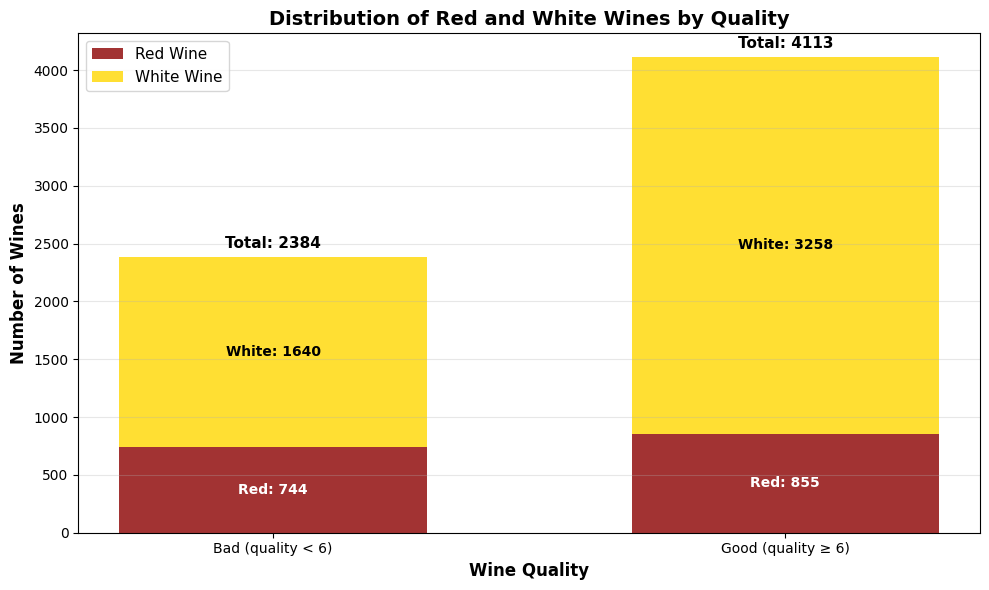

Dataset: 6497 samples, 11 features
  Red wines:   1599 (744 bad, 855 good)
  White wines: 4898 (1640 bad, 3258 good)

Train: 5197, Test: 1300
Class distribution: 3286 positive, 1911 negative


Start Logistic Regression
Starting grid search for 18 parameter combinations...
[1/18] Params: {'eta': 0.1, 'lam': 0.01, 'T': 500} -> CV Accuracy: 0.6892 (+/- 0.0045)
[2/18] Params: {'eta': 0.1, 'lam': 0.01, 'T': 1000} -> CV Accuracy: 0.6941 (+/- 0.0184)
[3/18] Params: {'eta': 0.1, 'lam': 0.01, 'T': 2000} -> CV Accuracy: 0.7019 (+/- 0.0110)
[4/18] Params: {'eta': 0.1, 'lam': 0.001, 'T': 500} -> CV Accuracy: 0.6862 (+/- 0.0155)
[5/18] Params: {'eta': 0.1, 'lam': 0.001, 'T': 1000} -> CV Accuracy: 0.6948 (+/- 0.0162)
[6/18] Params: {'eta': 0.1, 'lam': 0.001, 'T': 2000} -> CV Accuracy: 0.7066 (+/- 0.0178)
[7/18] Params: {'eta': 0.05, 'lam': 0.01, 'T': 500} -> CV Accuracy: 0.6829 (+/- 0.0146)
[8/18] Params: {'eta': 0.05, 'lam': 0.01, 'T': 1000} -> CV Accuracy: 0.6871 (+/- 0.0045)
[9/18] Params: {'eta'

In [ ]:
X_train, X_test, y_train, y_test = load_data()
best_models = parameters_selection(X_train, y_train)

In [14]:
best_models

{'Logistic Regression': (<__main__.LogisticRegression at 0x7d63582aa0c0>,
  {'eta': 0.1, 'lam': 0.001, 'T': 2000},
  np.float64(0.7065653721943159)),
 'SVM': (<__main__.SVM at 0x7d63535dfce0>,
  {'lam': 0.1, 'T': 2000},
  np.float64(0.6973220204530515)),
 'Gauss kernel logistic regression': (<__main__.KernelLogisticRegression at 0x7d6353593950>,
  {'eta': 0.1, 'lam': 0.01, 'gamma': 1, 'T': 1000, 'kernel': 'gauss'},
  np.float64(0.796602807509992)),
 'Polynomial Kernel logistic regression': (<__main__.KernelLogisticRegression at 0x7d6353593fb0>,
  {'lam': 0.01, 'T': 1000, 'kernel': 'poly', 'degree': 1},
  np.float64(0.73889417427346)),
 'Gauss kernel SVM': (<__main__.KernelSVM at 0x7d6374ea5730>,
  {'lam': 0.001, 'T': 1000, 'kernel': 'gauss', 'gamma': 1},
  np.float64(0.7111826101910227)),
 'Polynomial Kernel SVM': (<__main__.KernelSVM at 0x7d6361ef4920>,
  {'lam': 0.001, 'T': 1000, 'kernel': 'poly', 'degree': 1},
  np.float64(0.6753804321194823))}

## Main run

In [16]:
def main(mode='default'):
    """
    Main function to train and evaluate models.

    mode: str, 'default' to train with default parameters
    'tuned' - use pre-tuned models from best_models variable
    """
    X_train, X_test, y_train, y_test = load_data()

    if mode == 'default':
        print("\nTraining Logistic Regression (default parameters)")
        lr = LogisticRegression(eta=0.01, lam=1.0, T=1000)
        lr.fit(X_train, y_train)
        lr_train_acc = accuracy(y_train, lr.predict(X_train))

        print("\nTraining SVM (default parameters)")
        svm = SVM(lam=0.01, T=1000)
        svm.fit(X_train, y_train)
        svm_train_acc = accuracy(y_train, svm.predict(X_train))

        print("\nTraining Kernel LR (Gaussian, default parameters)")
        klr_gauss = KernelLogisticRegression(kernel='gauss', gamma=0.1, eta=0.01, lam=1.0, T=1000)
        klr_gauss.fit(X_train, y_train)
        klr_gauss_train_acc = accuracy(y_train, klr_gauss.predict(X_train))

        print("\nTraining Kernel LR (Polynomial, default parameters)")
        klr_poly = KernelLogisticRegression(kernel='poly', degree=3, eta=0.01, lam=1.0, T=1000)
        klr_poly.fit(X_train, y_train)
        klr_poly_train_acc = accuracy(y_train, klr_poly.predict(X_train))

        print("\nTraining Kernel SVM (Gaussian, default parameters)")
        ksvm_gauss = KernelSVM(kernel='gauss', gamma=0.1, lam=0.01, T=1000)
        ksvm_gauss.fit(X_train, y_train)
        ksvm_gauss_train_acc = accuracy(y_train, ksvm_gauss.predict(X_train))

        print("\nTraining Kernel SVM (Polynomial, default parameters)")
        ksvm_poly = KernelSVM(kernel='poly', degree=3, lam=0.01, T=1000)
        ksvm_poly.fit(X_train, y_train)
        ksvm_poly_train_acc = accuracy(y_train, ksvm_poly.predict(X_train))

    elif mode == 'tuned':
        print("\nUsing pre-tuned models from grid search")
        # Model
        lr = best_models['Logistic Regression'][0]
        # Accuracy
        lr_train_acc = best_models['Logistic Regression'][2]

        svm = best_models['SVM'][0]
        svm_train_acc = best_models['SVM'][2]

        klr_gauss = best_models['Gauss kernel logistic regression'][0]
        klr_gauss_train_acc = best_models['Gauss kernel logistic regression'][2]

        klr_poly = best_models['Polynomial Kernel logistic regression'][0]
        klr_poly_train_acc = best_models['Polynomial Kernel logistic regression'][2]

        ksvm_gauss = best_models['Gauss kernel SVM'][0]
        ksvm_gauss_train_acc = best_models['Gauss kernel SVM'][2]

        ksvm_poly = best_models['Polynomial Kernel SVM'][0]
        ksvm_poly_train_acc = best_models['Polynomial Kernel SVM'][2]
    else:
        raise ValueError("mode must be 'default' or 'tuned'")

    # Evaluate on test set
    lr_acc = evaluate(y_test, lr.predict(X_test), "Logistic Regression")
    svm_acc = evaluate(y_test, svm.predict(X_test), "SVM (Pegasos)")
    klr_gauss_acc = evaluate(y_test, klr_gauss.predict(X_test), "Kernel LR (Gaussian)")
    klr_poly_acc = evaluate(y_test, klr_poly.predict(X_test), "Kernel LR (Polynomial)")
    ksvm_gauss_acc = evaluate(y_test, ksvm_gauss.predict(X_test), "Kernel SVM (Gaussian)")
    ksvm_poly_acc = evaluate(y_test, ksvm_poly.predict(X_test), "Kernel SVM (Polynomial)")

    # Learning Curves chart
    fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))

    iterations_lr = np.arange(0, len(lr.losses) * 50, 50)
    axes1[0, 0].plot(iterations_lr, lr.losses, linewidth=2, color='steelblue')
    axes1[0, 0].set_xlabel('Iterations', fontsize=10)
    axes1[0, 0].set_ylabel('Loss', fontsize=10)
    axes1[0, 0].set_title('Logistic Regression', fontweight='bold')
    axes1[0, 0].grid(True, alpha=0.3)

    iterations_svm = np.arange(0, len(svm.losses) * 50, 50)
    axes1[0, 1].plot(iterations_svm, svm.losses, linewidth=2, color='steelblue')
    axes1[0, 1].set_xlabel('Iterations', fontsize=10)
    axes1[0, 1].set_ylabel('Loss', fontsize=10)
    axes1[0, 1].set_title('SVM (Pegasos)', fontweight='bold')
    axes1[0, 1].grid(True, alpha=0.3)

    iterations_klr_g = np.arange(0, len(klr_gauss.losses) * 50, 50)
    axes1[0, 2].plot(iterations_klr_g, klr_gauss.losses, linewidth=2, color='green')
    axes1[0, 2].set_xlabel('Iterations', fontsize=10)
    axes1[0, 2].set_ylabel('Loss', fontsize=10)
    axes1[0, 2].set_title('Kernel LR (Gaussian)', fontweight='bold')
    axes1[0, 2].grid(True, alpha=0.3)

    iterations_klr_p = np.arange(0, len(klr_poly.losses) * 50, 50)
    axes1[1, 0].plot(iterations_klr_p, klr_poly.losses, linewidth=2, color='green')
    axes1[1, 0].set_xlabel('Iterations', fontsize=10)
    axes1[1, 0].set_ylabel('Loss', fontsize=10)
    axes1[1, 0].set_title('Kernel LR (Polynomial)', fontweight='bold')
    axes1[1, 0].grid(True, alpha=0.3)

    iterations_ksvm_g = np.arange(0, len(ksvm_gauss.losses) * 50, 50)
    axes1[1, 1].plot(iterations_ksvm_g, ksvm_gauss.losses, linewidth=2, color='coral')
    axes1[1, 1].set_xlabel('Iterations', fontsize=10)
    axes1[1, 1].set_ylabel('Loss', fontsize=10)
    axes1[1, 1].set_title('Kernel SVM (Gaussian)', fontweight='bold')
    axes1[1, 1].grid(True, alpha=0.3)

    iterations_ksvm_p = np.arange(0, len(ksvm_poly.losses) * 50, 50)
    axes1[1, 2].plot(iterations_ksvm_p, ksvm_poly.losses, linewidth=2, color='coral')
    axes1[1, 2].set_xlabel('Iterations', fontsize=10)
    axes1[1, 2].set_ylabel('Loss', fontsize=10)
    axes1[1, 2].set_title('Kernel SVM (Polynomial)', fontweight='bold')
    axes1[1, 2].grid(True, alpha=0.3)

    fig1.suptitle('Learning Curves for All Models', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('learning_curves_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Train vs Test Accuracy Comparison
    fig2, ax2 = plt.subplots(figsize=(14, 8))

    models = ['LR', 'SVM', 'K-LR\n(Gauss)', 'K-LR\n(Poly)', 'K-SVM\n(Gauss)', 'K-SVM\n(Poly)']
    train_accs = [lr_train_acc, svm_train_acc, klr_gauss_train_acc,
                  klr_poly_train_acc, ksvm_gauss_train_acc, ksvm_poly_train_acc]
    test_accs = [lr_acc, svm_acc, klr_gauss_acc, klr_poly_acc, ksvm_gauss_acc, ksvm_poly_acc]

    x = np.arange(len(models))
    width = 0.35

    bars1 = ax2.bar(x - width/2, train_accs, width, label='Train Accuracy',
                    color='lightblue', alpha=0.8, edgecolor='black')
    bars2 = ax2.bar(x + width/2, test_accs, width, label='Test Accuracy',
                    color='lightcoral', alpha=0.8, edgecolor='black')

    ax2.set_xlabel('Models', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax2.set_title('Train vs Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, fontsize=10)
    ax2.set_ylim([0, 1])
    ax2.legend(fontsize=11, loc='lower right')
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    # Add train-test gap
    for i, (train, test) in enumerate(zip(train_accs, test_accs)):
        gap = train - test
        # Significant overfitting
        if gap > 0.05:
            ax2.plot([i, i], [test, train], 'r--', linewidth=2, alpha=0.5)

    plt.tight_layout()
    plt.savefig('train_vs_test_accuracy.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Summary Comparison
    fig3, axes3 = plt.subplots(1, 2, figsize=(14, 6))

    # Test Accuracy Comparison
    colors = ['steelblue', 'steelblue', 'green', 'green', 'coral', 'coral']
    bars = axes3[0].bar(models, test_accs, color=colors, alpha=0.7, edgecolor='black')
    axes3[0].set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
    axes3[0].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
    axes3[0].set_ylim([0, 1])
    axes3[0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(test_accs):
        axes3[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9, fontweight='bold')

    # Linear vs Kernel methods
    method_names = ['Linear\nMethods', 'Kernel\nMethods']
    linear_avg = np.mean([lr_acc, svm_acc])
    kernel_avg = np.mean([klr_gauss_acc, klr_poly_acc, ksvm_gauss_acc, ksvm_poly_acc])
    avg_accs = [linear_avg, kernel_avg]

    bars = axes3[1].bar(method_names, avg_accs, color=['steelblue', 'coral'],
                        alpha=0.7, edgecolor='black', width=0.6)
    axes3[1].set_ylabel('Average Test Accuracy', fontsize=11, fontweight='bold')
    axes3[1].set_title('Linear vs Kernel Methods', fontsize=12, fontweight='bold')
    axes3[1].set_ylim([0, 1])
    axes3[1].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(avg_accs):
        axes3[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig('model_comparison_summary.png', dpi=300, bbox_inches='tight')
    plt.show()


    all_models_names = ['LR', 'SVM', 'K-LR (Gauss)', 'K-LR (Poly)', 'K-SVM (Gauss)', 'K-SVM (Poly)']
    all_test_accs = [lr_acc, svm_acc, klr_gauss_acc, klr_poly_acc, ksvm_gauss_acc, ksvm_poly_acc]

    best_idx = np.argmax(all_test_accs)
    print(f"\nBest model: {all_models_names[best_idx]} (Test Acc: {all_test_accs[best_idx]:.4f})")


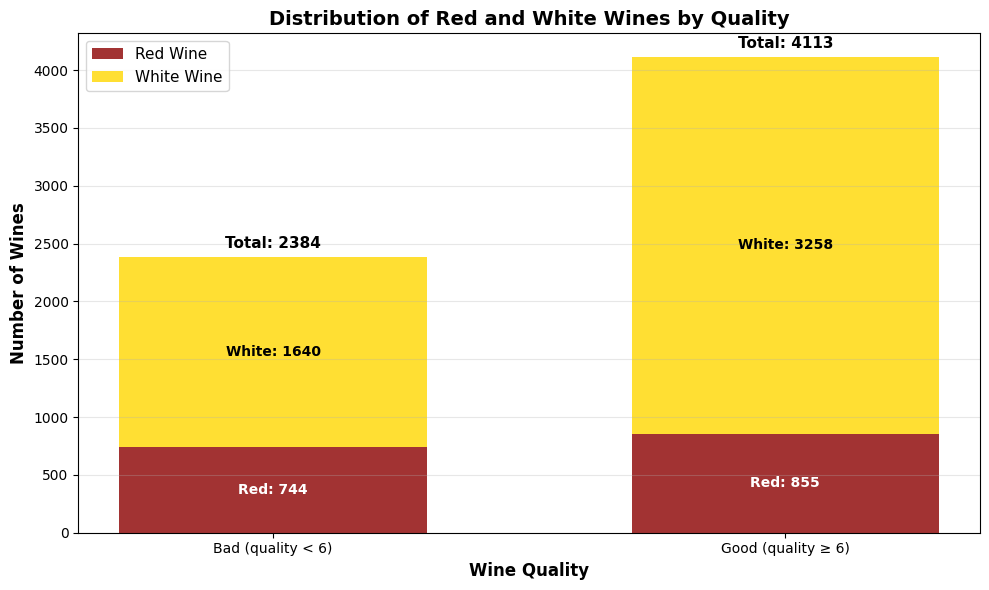

Dataset: 6497 samples, 11 features
  Red wines:   1599 (744 bad, 855 good)
  White wines: 4898 (1640 bad, 3258 good)

Train: 5197, Test: 1300
Class distribution: 3292 positive, 1905 negative


Using pre-tuned models from grid search

Logistic Regression:
  Accuracy:  0.6900
  Precision: 0.8297
  Recall:    0.6407
  F1-Score:  0.7230

SVM (Pegasos):
  Accuracy:  0.6823
  Precision: 0.8238
  Recall:    0.6322
  F1-Score:  0.7154

Kernel LR (Gaussian):
  Accuracy:  0.9523
  Precision: 0.9545
  Recall:    0.9708
  F1-Score:  0.9626

Kernel LR (Polynomial):
  Accuracy:  0.7569
  Precision: 0.7809
  Recall:    0.8551
  F1-Score:  0.8163

Kernel SVM (Gaussian):
  Accuracy:  0.7662
  Precision: 0.8066
  Recall:    0.8283
  F1-Score:  0.8173

Kernel SVM (Polynomial):
  Accuracy:  0.5408
  Precision: 0.6155
  Recall:    0.7272
  F1-Score:  0.6667


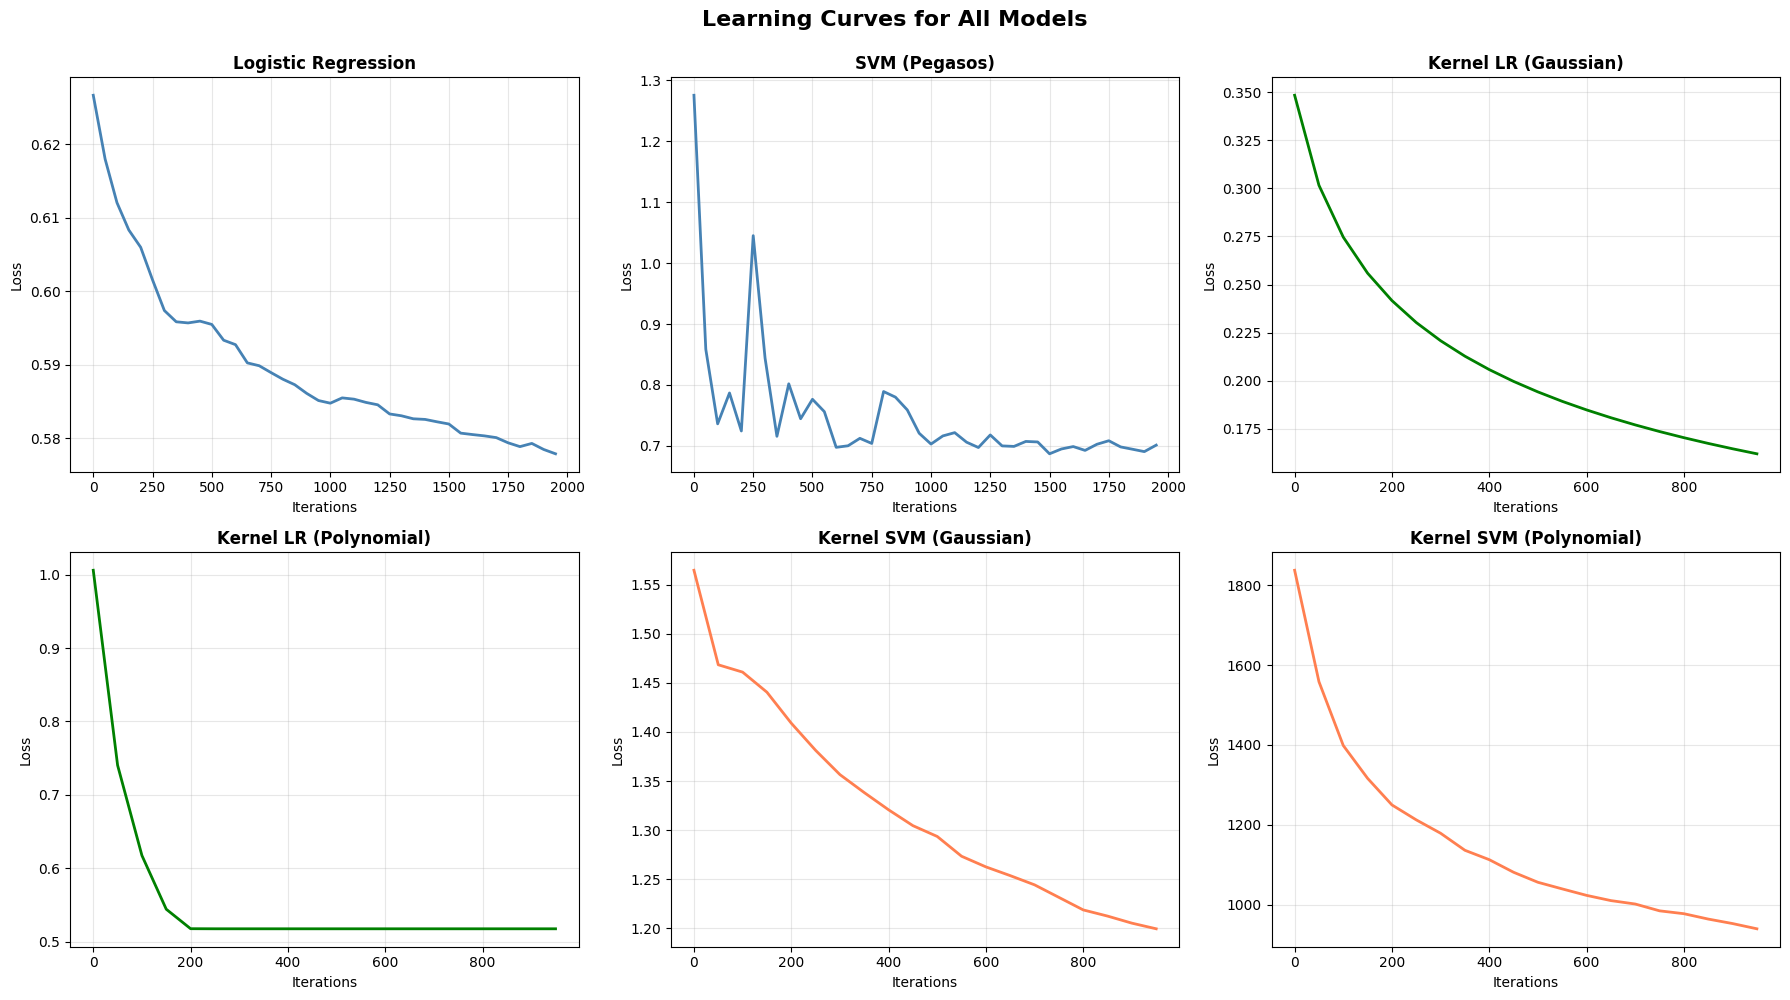

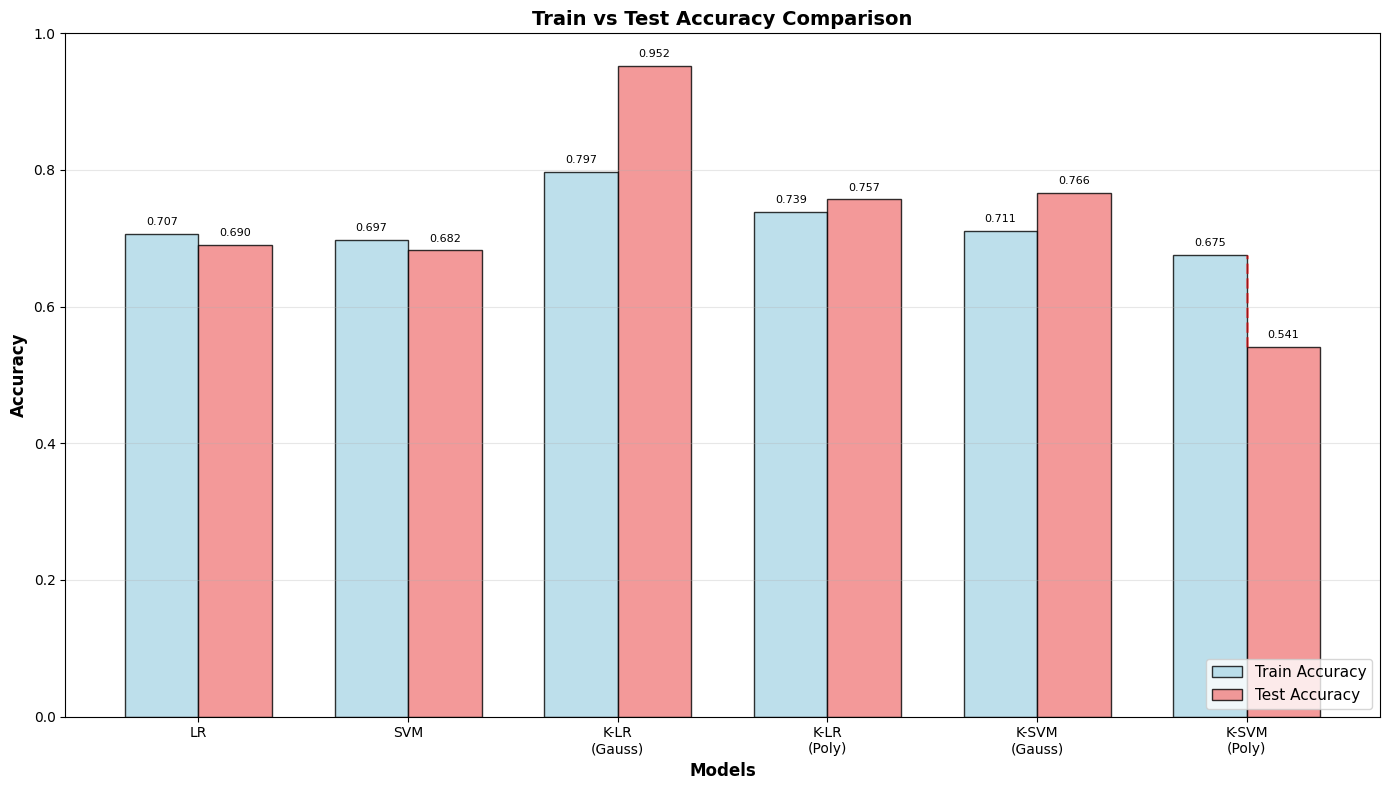

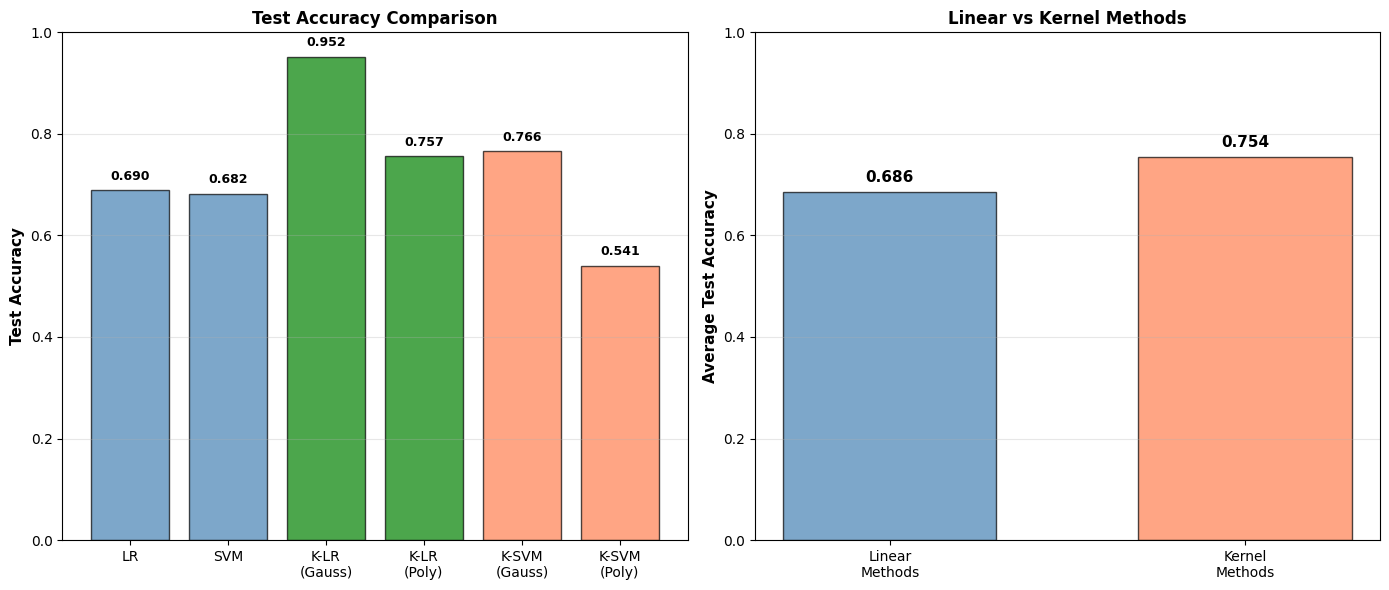


Best model: K-LR (Gauss) (Test Acc: 0.9523)


In [17]:
main('tuned')